### DGM – SABR

* **We have the SABR PDE as follows:**

$$
\frac{\partial u}{\partial t}
+ \frac{1}{2} \alpha^2 F^{2\beta} \frac{\partial^2 u}{\partial F^2}
+ \rho \nu \alpha^2 F^\beta \frac{\partial^2 u}{\partial F \partial \alpha}
+ \frac{1}{2} \nu^2 \alpha^2 \frac{\partial^2 u}{\partial \alpha^2}
= 0
$$

* **At $t = T$, we have the terminal condition:**

$$
u(T, F, \alpha) = (F - K)^+
$$

* **For $F \gg K$ and $F \ll K$, we have:**

$$
\begin{cases}
u(t, F, \alpha) \approx F - K, & \text{as } F \to \infty \\
u(t, F, \alpha) \approx 0, & \text{as } F \to 0
\end{cases}
$$



In [1]:
import math, time
import torch, torch.nn as nn, torch.optim as optim

def sampler_sabr(batch, T,
                 F_min, F_max,
                 A_min, A_max,
                 K_min, K_max,
                 beta_min, beta_max,
                 nu_min,   nu_max,
                 rho_min,  rho_max,
                 device):
    # sample interior points (t, F, A, K, β, ν, ρ) uniformly
    t  = torch.rand(batch,1, device=device) * T
    F  = F_min + (F_max - F_min) * torch.rand_like(t)
    A  = A_min + (A_max - A_min) * torch.rand_like(t)
    K  = K_min + (K_max - K_min) * torch.rand_like(t)
    β  = beta_min + (beta_max - beta_min) * torch.rand_like(t)
    ν  = nu_min   + (nu_max - nu_min)     * torch.rand_like(t)
    ρ  = rho_min  + (rho_max - rho_min)   * torch.rand_like(t)
    X_in = torch.cat([t, F, A, K, β, ν, ρ], dim=1)  # interior sample tensor

    # set terminal time for payoff condition
    X_T = X_in.clone()
    X_T[:,0:1] = T

    # sample boundary points at F=0 and F=F_max
    t_b  = torch.rand_like(t) * T
    A_b  = A_min + (A_max - A_min) * torch.rand_like(t)
    K_b  = K_min + (K_max - K_min) * torch.rand_like(t)
    β_b  = beta_min + (beta_max - beta_min) * torch.rand_like(t)
    ν_b  = nu_min   + (nu_max - nu_min)     * torch.rand_like(t)
    ρ_b  = rho_min  + (rho_max - rho_min)   * torch.rand_like(t)

    X_b0 = torch.cat([t_b, torch.zeros_like(F),      A_b, K_b, β_b, ν_b, ρ_b], dim=1)  # F=0 boundary
    X_b1 = torch.cat([t_b, torch.full_like(F, F_max), A_b, K_b, β_b, ν_b, ρ_b], dim=1)  # F=F_max boundary
    X_b  = torch.cat([X_b0, X_b1], dim=0)

    return X_in, X_T, X_b

def pde_residual_sabr(net, X):
    # enable gradient tracking on input
    X = X.clone().requires_grad_(True)
    u    = net(X)                                           # model output u(t,F,A,K,β,ν,ρ)
    grad = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
    u_t, u_F, u_A = grad[:,0:1], grad[:,1:2], grad[:,2:3]    # first derivatives

    # compute second derivatives for F and A
    u_F_grad = torch.autograd.grad(u_F, X, torch.ones_like(u_F), create_graph=True)[0]
    u_FF = u_F_grad[:,1:2]                                   # d^2u/dF^2
    u_FA = u_F_grad[:,2:3]                                   # d^2u/dF dA

    u_A_grad = torch.autograd.grad(u_A, X, torch.ones_like(u_A), create_graph=True)[0]
    u_AA = u_A_grad[:,2:3]                                   # d^2u/dA^2

    F, A = X[:,1:2], X[:,2:3]
    β, ν, ρ = X[:,4:5], X[:,5:6], X[:,6:7]

    # PDE residual for SABR model
    res = (u_t
           + 0.5 * A**2 * F**(2*β) * u_FF
           + ρ * ν * A**2 * F**β * u_FA
           + 0.5 * ν**2 * A**2 * u_AA)
    return res

def loss_fn_sabr(net, X_in, X_T, X_b, F_max):
    res      = pde_residual_sabr(net, X_in)                 # PDE residual loss
    loss_pde = (res**2).mean()

    payoff   = torch.relu(X_T[:,1:2] - X_T[:,3:4])          # terminal payoff (F-K)+
    loss_T   = ((net(X_T) - payoff)**2).mean()

    u_b = net(X_b)                                          # boundary predictions
    N   = X_b.shape[0] // 2
    bc0 = u_b[:N]                                           # at F=0 should be zero
    bc1 = u_b[N:] - (F_max - X_b[N:,3:4])                   # at F_max match intrinsic
    loss_b = (bc0**2).mean() + (bc1**2).mean()

    return loss_pde + loss_T + loss_b, loss_pde, loss_T, loss_b

class DGMBlock(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int):
        super().__init__()
        # define gating layers
        self.U_z = nn.Linear(in_dim, hidden_dim, bias=True)
        self.W_z = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U_g = nn.Linear(in_dim, hidden_dim, bias=True)
        self.W_g = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U_r = nn.Linear(in_dim, hidden_dim, bias=True)
        self.W_r = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.U_h = nn.Linear(in_dim, hidden_dim, bias=True)
        self.W_h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.act = nn.Tanh()

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, s_prev, s_first):
        z = self.act(self.U_z(x) + self.W_z(s_prev))        # update gate
        g = self.act(self.U_g(x) + self.W_g(s_first))       # forget gate
        r = self.act(self.U_r(x) + self.W_r(s_prev))        # reset gate
        h = self.act(self.U_h(x) + self.W_h(s_prev * r))    # candidate state
        s_next = (1.0 - g) * h + z * s_prev                 # next hidden state
        return s_next

class DGMNet(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, n_layers=3):
        super().__init__()
        # initial projection layer
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)

        # sequence of DGM blocks
        self.blocks = nn.ModuleList([
            DGMBlock(input_dim, hidden_dim) for _ in range(n_layers)
        ])

        # output layer to scalar value
        self.output_layer = nn.Linear(hidden_dim, 1)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

        self.act = nn.Tanh()

    def forward(self, x):
        s = self.act(self.input_layer(x))  # embed inputs
        s_first = s                        # store initial state
        for block in self.blocks:
            s = block(x, s, s_first)      # sequentially update state
        return self.output_layer(s)       # produce final output

if __name__ == "__main__":
    T = 1.0
    F_min, F_max = 60.0, 140.0
    A_min, A_max = 0.05, 0.15
    K_min, K_max = 95.0, 105.0
    beta_min, beta_max = 0.4, 1.0
    nu_min,   nu_max   = 0.1, 0.6
    rho_min,  rho_max  = -0.9, 0.9
    batch, epochs, lr = 2048, 12000, 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net = DGMNet().to(device)             # initialize DGM network
    opt = optim.Adam(net.parameters(), lr=lr)

    t0 = time.time()
    for ep in range(1, epochs+1):
        X_in, X_T, X_b = sampler_sabr(
            batch, T,
            F_min, F_max,
            A_min, A_max,
            K_min, K_max,
            beta_min, beta_max,
            nu_min, nu_max,
            rho_min, rho_max,
            device
        )                                 # sample training points
        loss, lpde, lT, lb = loss_fn_sabr(net, X_in, X_T, X_b, F_max)
        opt.zero_grad()
        loss.backward()
        opt.step()

        if ep % 500 == 0:
            print(f"Epoch {ep:>5} | total={loss.item():.3e} | PDE={lpde:.2e} | T={lT:.2e} | B={lb:.2e}")

    print(f"Finished in {time.time() - t0:.1f}s")  # training time
    torch.save(net.state_dict(), "SABR_DGM_universal.pth")  # save model
    print("Model saved → SABR_DGM_universal.pth")


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch   500 | total=9.325e-01 | PDE=6.55e-01 | T=1.27e-01 | B=1.51e-01
Epoch  1000 | total=3.178e-01 | PDE=2.22e-01 | T=8.49e-02 | B=1.06e-02
Epoch  1500 | total=2.372e-01 | PDE=1.85e-01 | T=4.37e-02 | B=8.45e-03
Epoch  2000 | total=2.402e-01 | PDE=1.75e-01 | T=3.21e-02 | B=3.30e-02
Epoch  2500 | total=1.543e-01 | PDE=1.08e-01 | T=3.50e-02 | B=1.12e-02
Epoch  3000 | total=7.749e-02 | PDE=5.35e-02 | T=2.18e-02 | B=2.15e-03
Epoch  3500 | total=9.831e-02 | PDE=8.40e-02 | T=1.14e-02 | B=2.84e-03
Epoch  4000 | total=5.388e-02 | PDE=3.39e-02 | T=1.70e-02 | B=2.98e-03
Epoch  4500 | total=6.508e-02 | PDE=4.51e-02 | T=1.95e-02 | B=5.44e-04
Epoch  5000 | total=3.897e-02 | PDE=2.76e-02 | T=1.08e-02 | B=5.28e-04
Epoch  5500 | total=4.094e-02 | PDE=2.73e-02 | T=9.57e-03 | B=4.04e-03
Epoch  6000 | total=3.290e-02 | PDE=2.45e-02 | T=7.96e-03 | B=4.14e-04
Epoch  6500 | total=3.245e-02 | PDE=1.49e-02 | T=1.06e-02 | B=6.93e-03
Epoch  7000 | total=2.061e-02 | PDE=1.45e-02 | T=5.27e-03 | B=8.60e-04
Epoch 

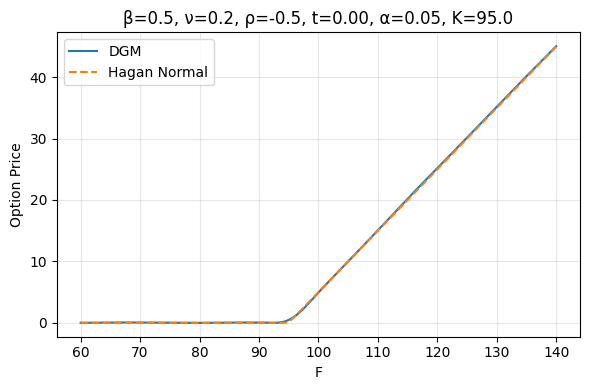

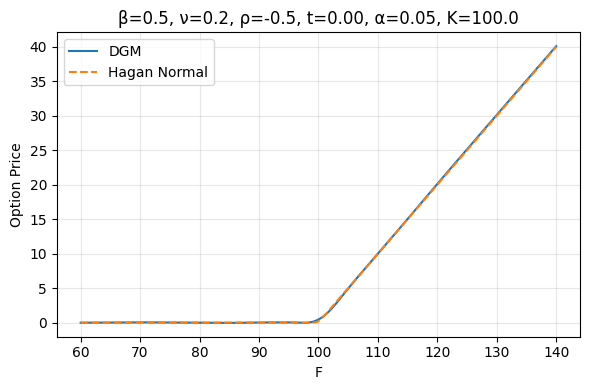

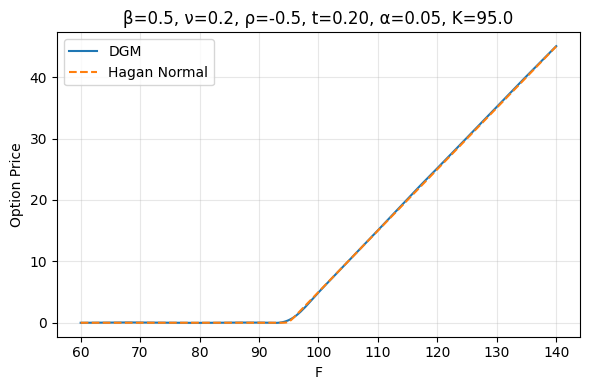

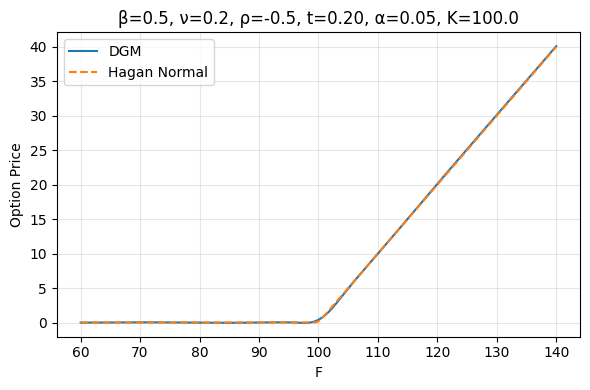

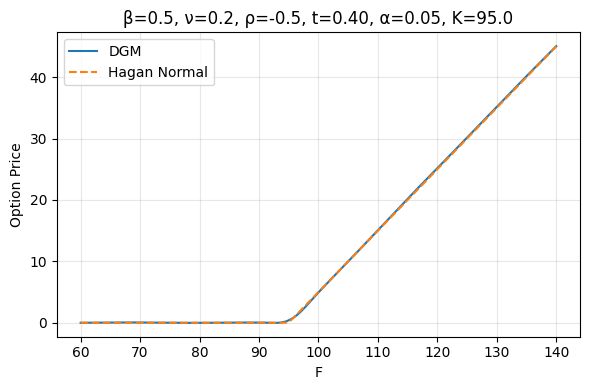

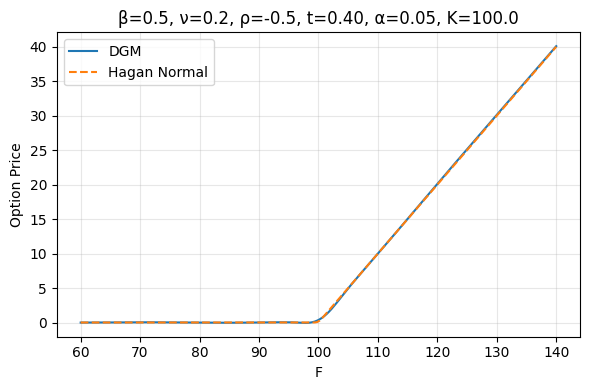

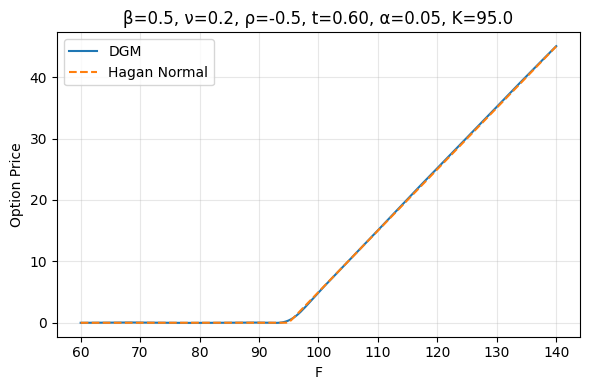

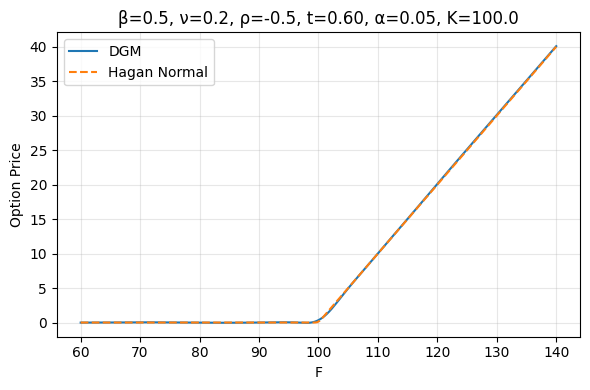

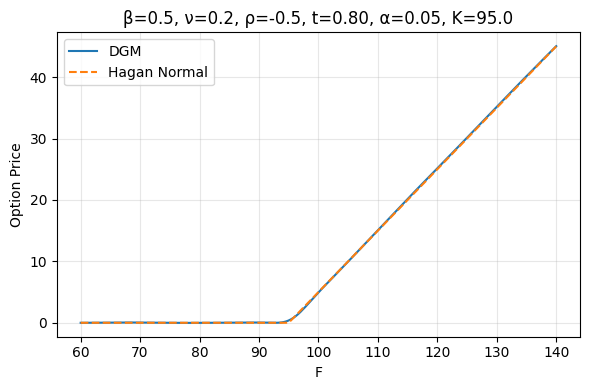

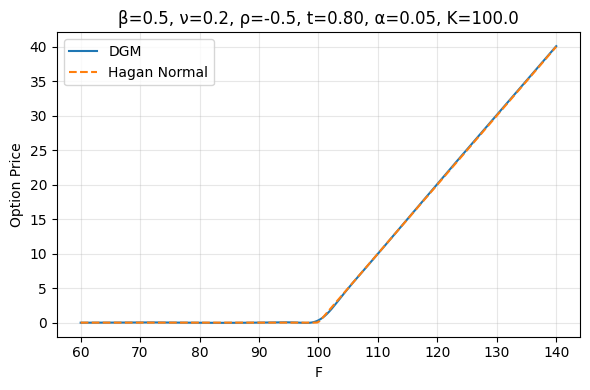

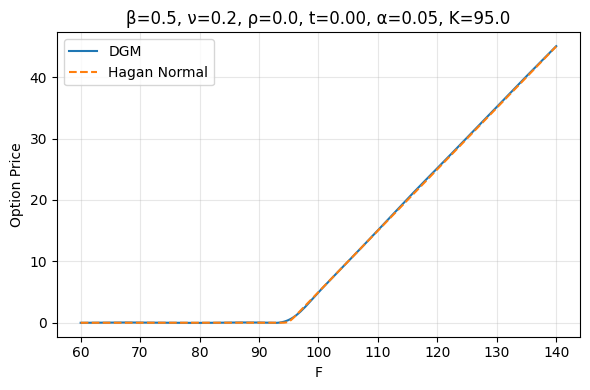

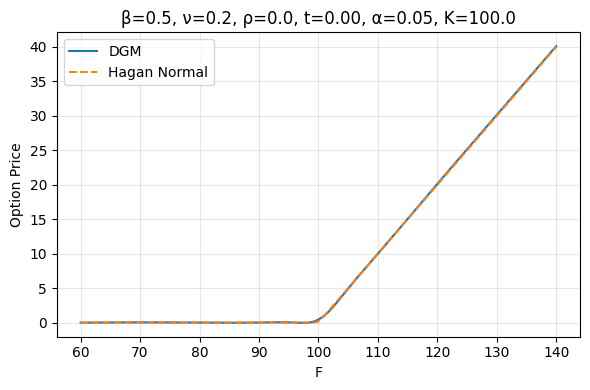

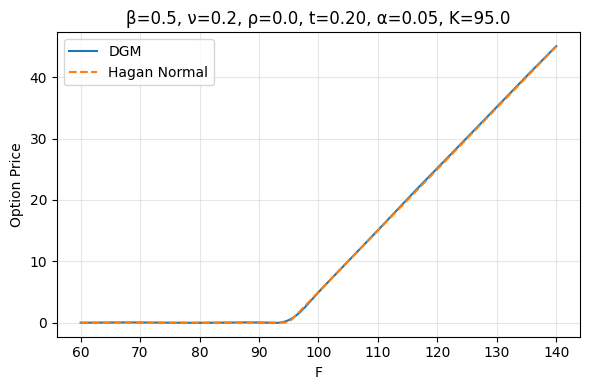

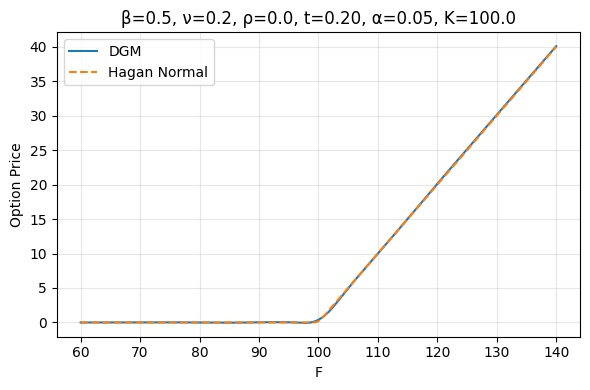

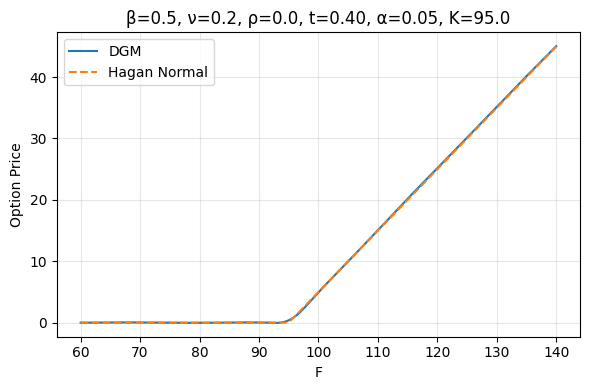

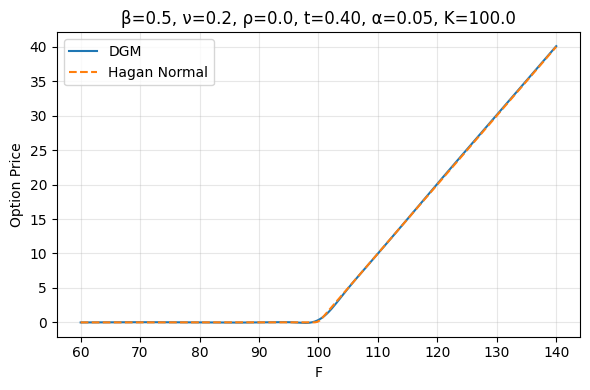

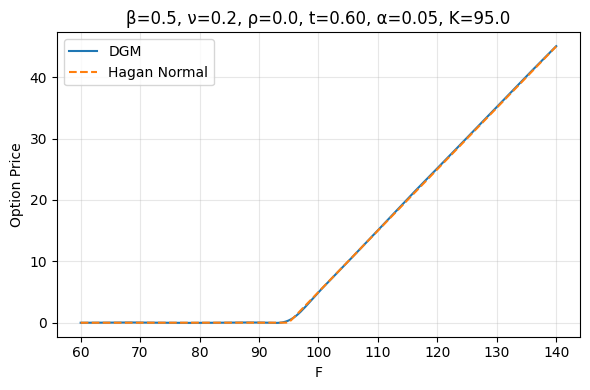

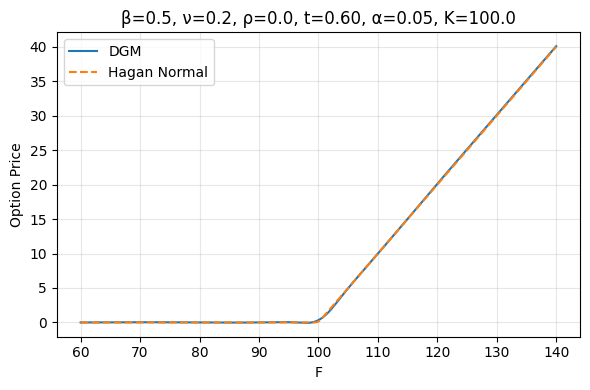

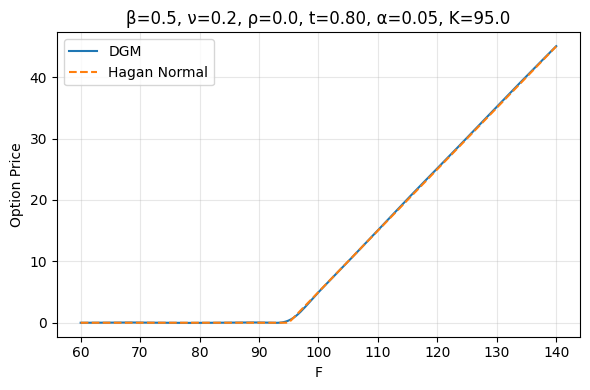

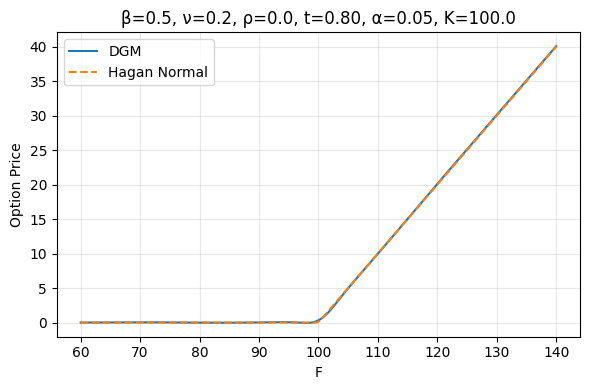

DGM vs Hagan-Normal
                                 AvgAbs    MaxAbs  AvgPct
beta nu  rho  t   alpha K                                
0.5  0.2 -0.5 0.0 0.05  95.0   0.082328  0.277356  2.7616
                        100.0  0.057123  0.253458  3.9642
              0.2 0.05  95.0   0.080847  0.253480  2.7994
                        100.0  0.056252  0.226158  1.7038
              0.4 0.05  95.0   0.078876  0.248808  2.9944
                        100.0  0.055136  0.234275  1.7216
              0.6 0.05  95.0   0.076750  0.262968  3.4978
                        100.0  0.053660  0.232412  1.7805
              0.8 0.05  95.0   0.075017  0.296088  1.4032
                        100.0  0.052195  0.233290  1.9194
          0.0 0.0 0.05  95.0   0.080715  0.267741  2.6505
                        100.0  0.056792  0.237605  3.7165
              0.2 0.05  95.0   0.079405  0.244501  2.6836
                        100.0  0.055959  0.219810  1.6675
              0.4 0.05  95.0   0.077603  0.239925  2

In [12]:
import math, pathlib
import torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def normal_vol(k, f, t, alpha, beta, rho, volvol):
    # compute Hagan’s SABR normal volatility approximation
    f_av = np.sqrt(f * k)
    A = -beta * (2 - beta) * alpha**2 / (24 * f_av**(2 - 2 * beta))
    B = rho * alpha * volvol * beta / (4 * f_av**(1 - beta))
    C = (2 - 3 * rho**2) * volvol**2 / 24
    FMKR = _f_minus_k_ratio(f, k, beta)  # forward-minus-strike ratio term
    ZXZ  = _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol)  # zeta/x(zeta) term
    return alpha * FMKR * ZXZ * (1 + (A + B + C) * t)

def _f_minus_k_ratio(f, k, beta):
    # handle small differences and beta≈1 separately
    eps = 1e-7
    if abs(f - k) > eps:
        if abs(1 - beta) > eps:
            return (1 - beta) * (f - k) / (f**(1 - beta) - k**(1 - beta))
        else:
            return (f - k) / np.log(f / k)
    return k**beta

def _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol):
    # compute zeta / x(zeta) factor
    eps = 1e-7
    f_av = np.sqrt(f * k)
    zeta = volvol * (f - k) / (alpha * f_av**beta)
    if abs(zeta) > eps:
        return zeta / _x(rho, zeta)
    return 1.0

def _x(rho, z):
    # helper for _zeta_over_x_of_zeta
    a = math.sqrt(1 - 2 * rho * z + z**2) + z - rho
    return math.log(a / (1 - rho))

def normal_call(k, f, t, v, r=0.0, cp='call'):
    # price under Bachelier (normal) model
    d = (f - k) / (v * math.sqrt(t))
    s = 1.0 if cp == 'call' else -1.0
    return math.exp(-r * t) * (s * (f - k) * norm.cdf(s * d) +
                               v * math.sqrt(t / (2 * math.pi)) * math.exp(-0.5 * d * d))

# load pre-trained model for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DGMNet().to(device)
net.load_state_dict(torch.load("SABR_DGM_universal.pth", map_location=device))
net.eval()

# parameter sweeps
beta_vals  = [0.5]
nu_vals    = [0.2]
rho_vals   = [-0.5, 0.0]
alpha_vals = [0.05]
K_values   = [95.0, 100.0]

# forward price grid
F_vals   = np.linspace(60, 140, 200, dtype=np.float32)
F_tensor = torch.tensor(F_vals, device=device).unsqueeze(1)

T_total  = 1.0
# time slices excluding maturity
t_list   = np.linspace(0.0, T_total, 5, endpoint=False, dtype=np.float32)

# prepare output directory
out_dir  = pathlib.Path("figs_SABR_normal"); out_dir.mkdir(exist_ok=True)
metrics  = []

with torch.no_grad():
    for beta in beta_vals:
        for nu in nu_vals:
            for rho in rho_vals:
                for t_fixed in t_list:
                    tau = T_total - t_fixed
                    t_tensor = torch.full_like(F_tensor, t_fixed)

                    for alpha in alpha_vals:
                        for K in K_values:
                            # construct input matrix for DGMNet
                            X = torch.cat([
                                t_tensor, F_tensor,
                                torch.full_like(F_tensor, alpha),
                                torch.full_like(F_tensor, K),
                                torch.full_like(F_tensor, beta),
                                torch.full_like(F_tensor, nu),
                                torch.full_like(F_tensor, rho)
                            ], dim=1).float()

                            u_pred = net(X).cpu().numpy().ravel()  # model prices

                            # compute benchmark Hagan normal prices
                            u_exact = np.array([
                                normal_call(
                                    K, float(f), tau,
                                    normal_vol(K, float(f), tau,
                                               alpha, beta, rho, nu)
                                )
                                for f in F_vals
                            ], dtype=np.float32)

                            # plot comparison
                            plt.figure(figsize=(6,4))
                            plt.plot(F_vals, u_pred, label="DGM")
                            plt.plot(F_vals, u_exact, "--", label="Hagan Normal")
                            plt.title(f"beta={beta}, nu={nu}, rho={rho}, t={t_fixed:.2f}, alpha={alpha}, K={K}")
                            plt.xlabel("F")
                            plt.ylabel("Option Price")
                            plt.legend()
                            plt.grid(alpha=0.3)
                            plt.tight_layout()
                            plt.show()

                            # record error metrics
                            err = np.abs(u_pred - u_exact)
                            rel = err[u_exact > 1e-1] / u_exact[u_exact > 1e-1]
                            metrics.append({
                                'beta': beta, 'nu': nu, 'rho': rho, 't': t_fixed,
                                'alpha': alpha, 'K': K,
                                'AvgAbs': err.mean(), 'MaxAbs': err.max(),
                                'AvgPct': rel.mean() * 100
                            })

# assemble results into DataFrame
df = pd.DataFrame(metrics).round({'AvgAbs':6, 'MaxAbs':6, 'AvgPct':4})
df.set_index(['beta','nu','rho','t','alpha','K'], inplace=True)
print("DGM vs Hagan-Normal")
print(df)


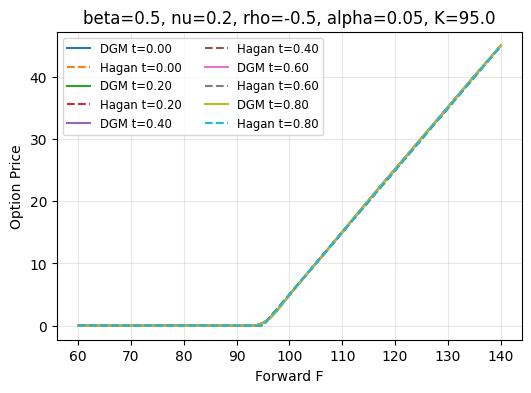

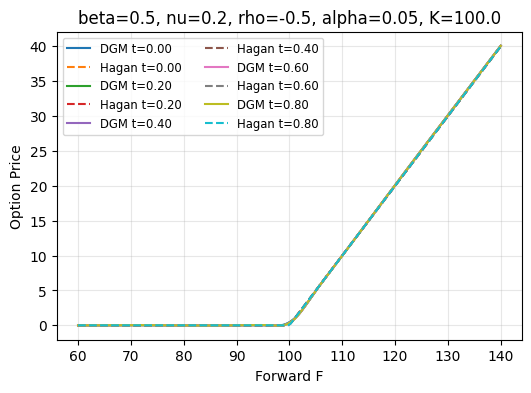

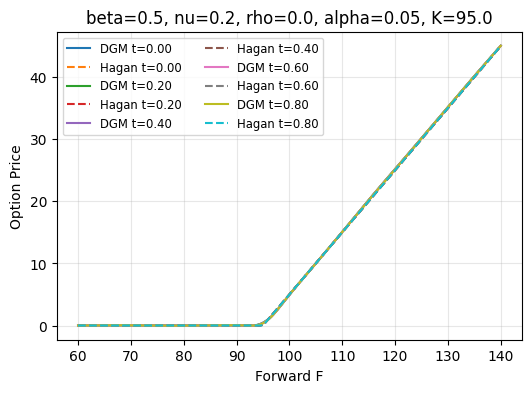

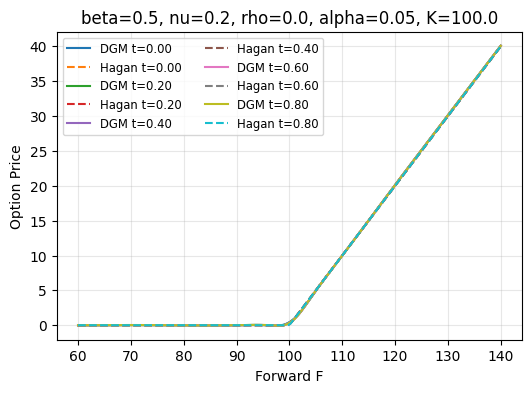

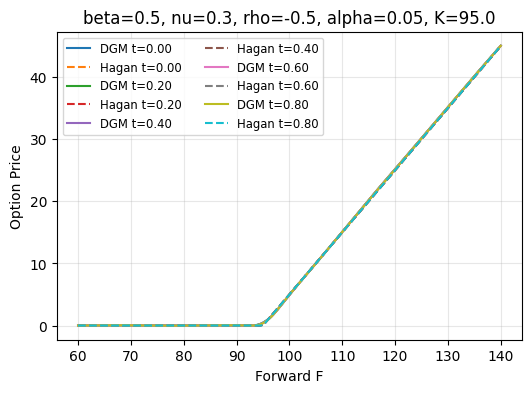

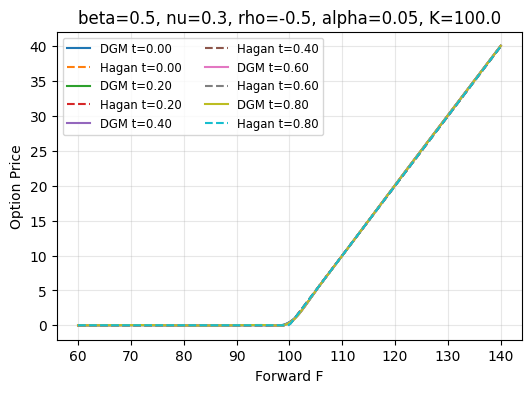

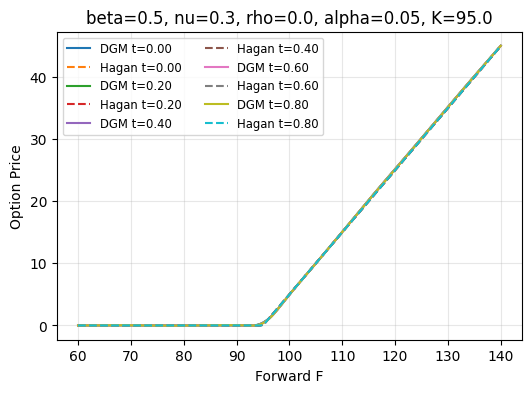

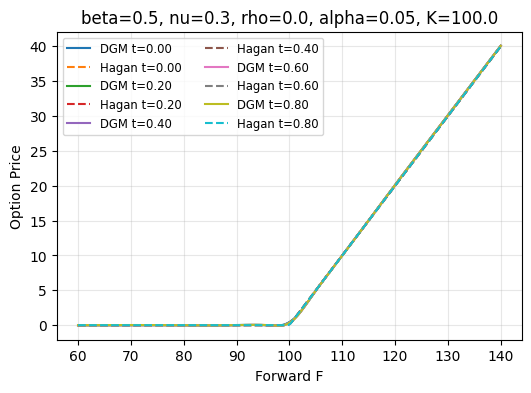

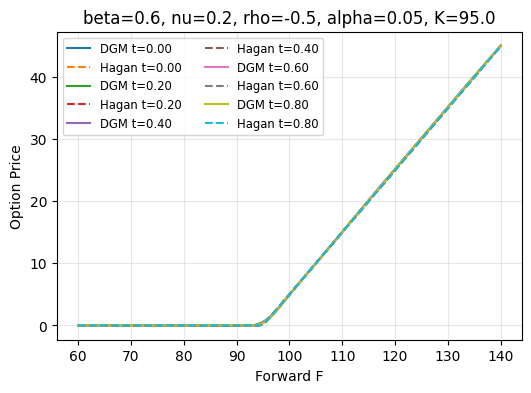

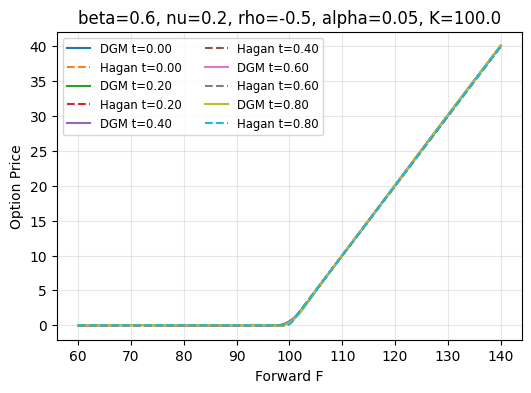

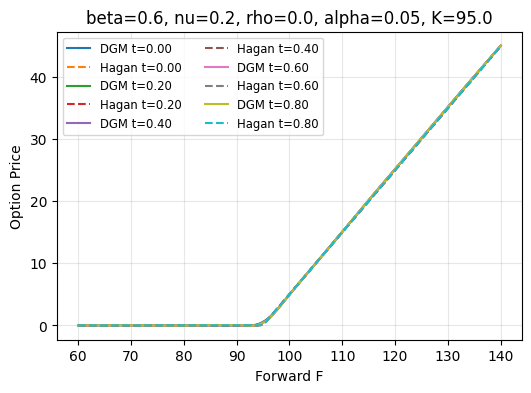

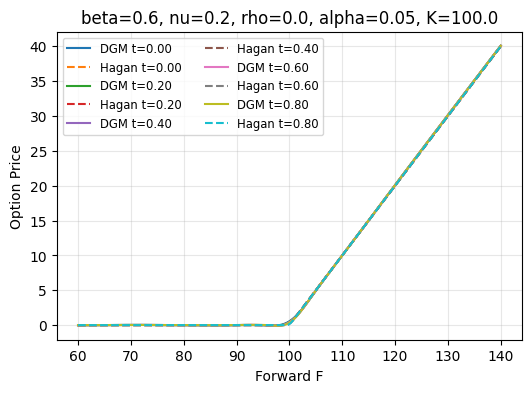

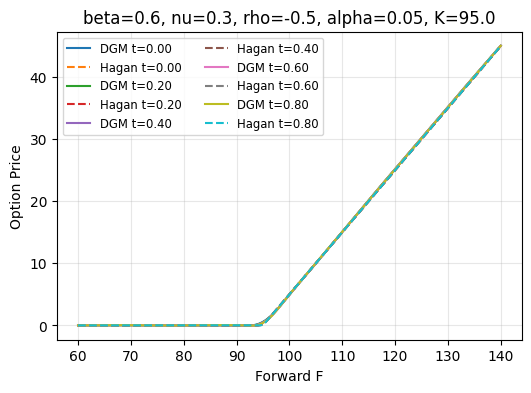

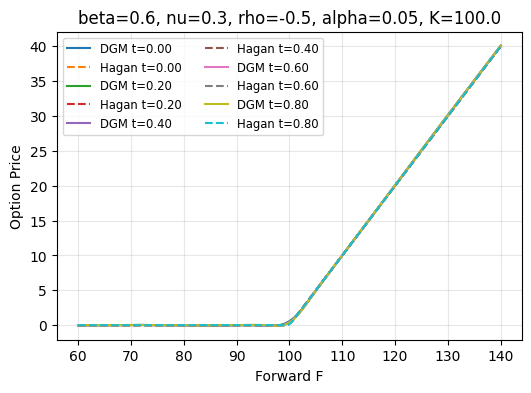

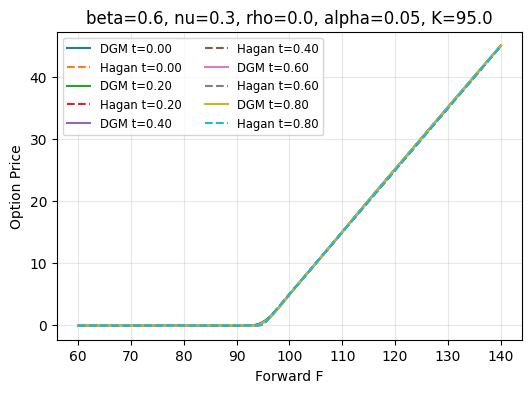

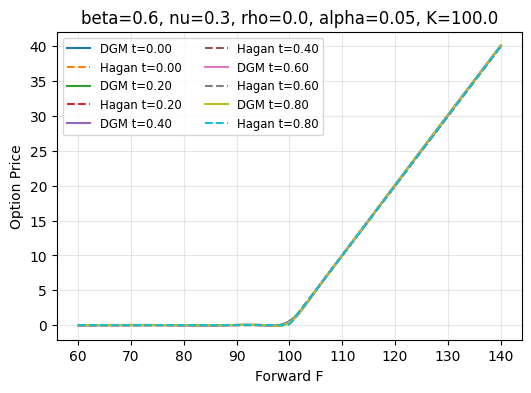

In [13]:
import math, pathlib
import torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DGMNet().to(device)
net.load_state_dict(torch.load("SABR_DGM_universal.pth", map_location=device))
net.eval()

# parameter sets to test
beta_vals  = [0.5, 0.6]
nu_vals    = [0.2, 0.3]
rho_vals   = [-0.5, 0.0]
alpha_vals = [0.05]
K_values   = [95.0, 100.0]

# forward price grid for evaluation
F_vals   = np.linspace(60, 140, 200, dtype=np.float32)
F_tensor = torch.tensor(F_vals, device=device).unsqueeze(1)

T_total  = 1.0
# time slices excluding maturity
t_list   = np.linspace(0.0, T_total, 5, endpoint=False, dtype=np.float32)

for beta in beta_vals:
    for nu in nu_vals:
        for rho in rho_vals:
            for alpha in alpha_vals:
                for K in K_values:
                    # start a new figure for this parameter combination
                    plt.figure(figsize=(6,4))
                    for t_fixed in t_list:
                        tau = T_total - t_fixed
                        # construct batch input for fixed t
                        t_tensor = torch.full_like(F_tensor, t_fixed)
                        X = torch.cat([
                            t_tensor,                     # time
                            F_tensor,                     # forward price
                            torch.full_like(F_tensor, alpha),  # alpha param
                            torch.full_like(F_tensor, K),      # strike K
                            torch.full_like(F_tensor, beta),   # beta param
                            torch.full_like(F_tensor, nu),     # vol-of-vol nu
                            torch.full_like(F_tensor, rho)     # correlation rho
                        ], dim=1).float()

                        # model prediction
                        with torch.no_grad():
                            u_pred = net(X).cpu().numpy().ravel()

                        # compute Hagan normal benchmark
                        u_exact = np.array([
                            normal_call(
                                K, float(f), tau,
                                normal_vol(K, float(f), tau,
                                           alpha, beta, rho, nu)
                            )
                            for f in F_vals
                        ], dtype=np.float32)

                        # plot model vs. benchmark for this time slice
                        plt.plot(F_vals, u_pred, label=f"DGM t={t_fixed:.2f}")
                        plt.plot(F_vals, u_exact, "--", label=f"Hagan t={t_fixed:.2f}")

                    plt.title(f"beta={beta}, nu={nu}, rho={rho}, alpha={alpha}, K={K}")
                    plt.xlabel("Forward F")
                    plt.ylabel("Option Price")
                    plt.legend(ncol=2, fontsize="small")
                    plt.grid(alpha=0.3)
                    plt.show()
